In [1]:
!pip install sastrawi

     |████████████████████████████████| 209 kB 4.4 MB/s 


In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
!pip install googletrans

     |████████████████████████████████| 55 kB 2.0 MB/s 
     |████████████████████████████████| 42 kB 1.2 MB/s 
     |████████████████████████████████| 1.3 MB 8.8 MB/s 
     |████████████████████████████████| 53 kB 2.2 MB/s 
     |████████████████████████████████| 65 kB 3.7 MB/s 
  Created wheel for googletrans: filename=googletrans-3.0.0-py3-none-any.whl size=15734 sha256=a8a07c611d6e69e7dc67f6b666a18194ea22f4a2e3de948f50672b90b1bc9d07
  Stored in directory: /root/.cache/pip/wheels/20/da/eb/a54579056f265eede0417df537dd56d3df5b9eb2b25df0003d
Successfully built googletrans


In [4]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
import pytz 
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import ast
import string
from wordcloud import WordCloud
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from googletrans import Translator

# Import Data

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
df = pd.read_csv('/content/drive/MyDrive/data_covid/data/this/byu_indonesia.csv')
df.head()

,id,created_at,source,original_text,clean_text,lang,favorite_count,retweet_count,original_author,possibly_sensitive,hashtags,user_mentions,place,place_coord_boundaries
0,1478564382783119362,Wed Jan 05 03:09:53 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",@byu_id apa aku harus nunggu ber-jam² hingga a...,nunggu ber jam hingga aplikasi terbuka,in,0,0,rickjak16,False,NaN,byu_id,Planet Namex,NaN
1,1478561754284060674,Wed Jan 05 02:59:27 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",Min @byu_id tolong jawab lah. Jangan di skip.,min jawab skip,in,0,0,Oghee_1900,NaN,NaN,byu_id,"DKI Jakarta, Indonesia",NaN
2,1478558087564836865,Wed Jan 05 02:44:53 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",@byu_id min beberapa hari belakangan ini kok s...,min sinyal by tidak stabil hp nokia pluslokasi...,in,0,0,Andi_Pi14,NaN,NaN,byu_id,Indonesia,NaN
3,1478556956310659074,Wed Jan 05 02:40:23 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",ada\n(selalu ada buat teman)\ngokil\n(tingkah ...,teman gila tingkah gila kumpul kepomasa sih,in,0,0,AlRob1179,NaN,NaN,byu_id,"Medan Timur, Indonesia",NaN
4,1478555575197732864,Wed Jan 05 02:34:54 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",@SpeciaIONEe @worksfess @IndosatCare @triindon...,mengadopsi bebas aktif nomor hahaha,in,0,0,bangvalash,NaN,NaN,"SpeciaIONEe, worksfess, IndosatCare, triindone...","Mars, PA",NaN


In [8]:
df.shape

(4522, 14)

Dataset that we collected is 4522 items. But I assume there could be document that duplicated. Let's see.

In [9]:
# checking number of duplicated
df.duplicated().sum()

2227

Yaps, there are almost 50% documents that duplicated. We're going to remove it.

In [10]:
df = df.drop_duplicates()
print(df.shape)
df.head()

(2295, 14)


,id,created_at,source,original_text,clean_text,lang,favorite_count,retweet_count,original_author,possibly_sensitive,hashtags,user_mentions,place,place_coord_boundaries
0,1478564382783119362,Wed Jan 05 03:09:53 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",@byu_id apa aku harus nunggu ber-jam² hingga a...,nunggu ber jam hingga aplikasi terbuka,in,0,0,rickjak16,False,NaN,byu_id,Planet Namex,NaN
1,1478561754284060674,Wed Jan 05 02:59:27 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",Min @byu_id tolong jawab lah. Jangan di skip.,min jawab skip,in,0,0,Oghee_1900,NaN,NaN,byu_id,"DKI Jakarta, Indonesia",NaN
2,1478558087564836865,Wed Jan 05 02:44:53 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",@byu_id min beberapa hari belakangan ini kok s...,min sinyal by tidak stabil hp nokia pluslokasi...,in,0,0,Andi_Pi14,NaN,NaN,byu_id,Indonesia,NaN
3,1478556956310659074,Wed Jan 05 02:40:23 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",ada\n(selalu ada buat teman)\ngokil\n(tingkah ...,teman gila tingkah gila kumpul kepomasa sih,in,0,0,AlRob1179,NaN,NaN,byu_id,"Medan Timur, Indonesia",NaN
4,1478555575197732864,Wed Jan 05 02:34:54 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",@SpeciaIONEe @worksfess @IndosatCare @triindon...,mengadopsi bebas aktif nomor hahaha,in,0,0,bangvalash,NaN,NaN,"SpeciaIONEe, worksfess, IndosatCare, triindone...","Mars, PA",NaN


------------------------------------------
#Cleaning

We actually done with cleaning in crawling session. But, here I still find the null dataset, maybe it caused by cleaning step before. So, what we do is replace the null clean_text using original_text. And we do cleansing again.

In [11]:
# Number of clean text that are null
len(df[df['clean_text'].isnull()==True])

78

In [12]:
# see the original text of the null clean text
print(df[df['clean_text'].isnull()==True]['original_text'][31:50]) # not duplicated
print('-' * 100)
print(df[df['clean_text'].isnull()==True]['original_text'][11:30]) # duplicated




817             @heyywell @byu_id https://t.co/QBxihYLLkv
847                       @byu_id https://t.co/M1kVC9Po2f
899     @andrienja @lathofya @myXL @myXLCare @byu_id ?...
910                                               @byu_id
937                       @tapirberenang @byu_id Sama pak
971     @Elvanprnm @xxxjaeyongnist @THanungp @byu_id M...
973     @RAPP_9479 @arghatirta @byu_id https://t.co/7N...
1006           @ArtegaHapra @Muhamma14544837 @byu_id Sama
1015                       @aesmaniaz @byu_id udah bisa ?
1031                                              @byu_id
1038         @xxxjaeyongnist @myogiiskandar @byu_id belom
1046    @ThePlowboys @DunkingNDragons @Cottingham4 @da...
1113                         @byu_id 👎🏻👎🏻👎🏻👎🏻👎🏻👎🏻👎🏻👎🏻👎🏻👎🏻
1116                           @Svastiko @byu_id Waduh 🥴🥴
1133    Ini sampe kapan ya? @byu_id #byu_id https://t....
1176                              @ridlokaaf @byu_id Sama
1240                              @ridlokaaf @byu_id sama
1309          

Seems like there are people that spamming because they really upset using Byu provider, and those spamming just contains hashstag and mention byu_id. So, that's why the clean text or clean tweet are null. But sometimes they are tweeting just using the words that really commons, and it cleaned by stopwords.

So, what we do is just remove it.

In [13]:
# removing the null clean text
df = df.dropna(subset=['clean_text'])
df = df.reset_index(drop=True)

In [14]:
#checking null again
df.isnull().sum()

id                           0
created_at                   0
source                       0
original_text                0
clean_text                   0
lang                         0
favorite_count               0
retweet_count                0
original_author              0
possibly_sensitive        1807
hashtags                  2182
user_mentions              104
place                      867
place_coord_boundaries    2181
dtype: int64

**The phenomenom in our society is we used combination of Bahasa Indonesia and English at the same time.** As I know, Byu expanded their provider to overseas like they said in this article 
https://www.telkomsel.com/about-us/news/byu-jawab-kebutuhan-internetan-di-luar-negeri-dengan-paket-data-roaming-menggunakan

**So that, the possibility people or byu its self tweeting using english is high**. We're going to check it.

In [15]:
df[df['lang']!='in']['lang'].value_counts()

en      66
ja      40
tl      23
tr      17
und      7
fi       7
es       4
eu       3
de       3
pt       3
cs       3
et       3
it       3
hi       3
pl       3
lt       2
nl       2
ca       1
hu       1
ht       1
fr       1
da       1
sv       1
lang     1
no       1
Name: lang, dtype: int64

See! That actually happened. **What we do is translating those language to Bahasa Indonesia.**

In [16]:
def trans(x,src):
    translator = Translator()
    try:
        sentence = translator.translate(x, src=src,dest='id').text
    except:
        sentence = x
    return sentence

In [17]:
df['clean_text'] = df.apply(lambda x: trans(x['clean_text'],x['lang']) if(x['lang']!='in') else x['clean_text'],axis=1)

In [18]:
clean_text = df['clean_text'].copy()
clean_text.tail(15)

2202    setahun hamdallaah meskipun ku mengeluh signal...
2203           ganti kartu rusak menunya tidak bisa admin
2204    paket internet by sebulan paling tidak always ...
2205                   ramai ramai report kya seperti ini
2206                                         uchhh sayang
2207                                                kartu
2208                                paket internet setaun
2209                               jangankan byu prabayar
2210              tidak bulanan tahunan tidak ada uang by
2211    tidak respon dilihat loh komplain terkait kone...
2212                                  admin settingan apn
2213           jahat banget nyuruh istirahat duluan malam
2214                                          selamat kak
2215                 niat bikin provider gaksi anjg emosi
2216             sih monthiversary giniii buseh kalah doi
Name: clean_text, dtype: object

Yeah here we go. I still not satisfied yet for the result clean text. I want to add slang words like 'anjg', 'gaksi', 'signal', dll into the original words. What we do is modify again the slang word.

In [19]:
def repair_exaggeration(x):
    word_tokens = word_tokenize(x)
    new_x =''
    for i in word_tokens:
        if (i =='byu'):
            new = re.sub(r'(\w)\1\1+',r'\1\1',i)
            new_x = new_x +new+' '
        elif(i =='by'):
            new = 'byu'
            new_x = new_x +new+' '
        elif(i =='anjg'):
            new = 'anjing'
            new_x = new_x +new+' '
        elif(i =='signal'):
            new = 'sinyal'
            new_x = new_x +new+' '
        elif(i =='gaksi'):
            new = 'tidak sih'
            new_x = new_x +new+' '
        elif(i =='always'):
            new = 'selalu'
            new_x = new_x +new+' '
        elif(i =='min'):
            new = 'admin'
            new_x = new_x +new+' '
        elif(i =='gb'):
            new = 'gigabita'
            new_x = new_x +new+' '
        elif(i =='hp'):
            new = 'ponsel'
            new_x = new_x +new+' '
        else:
            new = re.sub(r'(\w)\1\1\1+',r'\1',i)
            new_x = new_x +new+' '
    return new_x

def del_word(x,key_list):
    n = len(key_list)
    word_tokens = word_tokenize(x)
    new_x =''
    for word in word_tokens:
        if word not in key_list:
            new_x = new_x+word+' '
    return new_x

def clean_tweets(tweet):
    my_file = open("/content/drive/MyDrive/byu/combined_stop_words.txt", "r")
    content = my_file.read()
    stop_words = content.split("\n")
    file_2  = open("/content/drive/MyDrive/byu/update_combined_slang_words.txt", "r")
    content2 = file_2.read()
    slang_words = ast.literal_eval(content2)
    my_file.close()
    file_2.close()

    tweet = tweet.lower()
    #after tweepy preprocessing the colon left remain after removing mentions
    #or RT sign in the beginning of the tweet
    tweet = re.sub(r':', '', tweet)
    tweet = re.sub(r'‚Ä¶', '', tweet)
    #replace consecutive non-ASCII characters with a space
    tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)

    #remove emojis from tweet
    #tweet = emoji_pattern.sub(r'', tweet)
    
    #remove punctuation manually
    tweet = re.sub('[^a-zA-Z]', ' ', tweet)
    
    #remove tags
    tweet=re.sub("&lt;/?.*?&gt;","&lt;&gt;",tweet)
    
    #remove digits and special chars
    tweet=re.sub("(\\d|\\W)+"," ",tweet)

    #remove other symbol from tweet
    tweet = re.sub(r'â', '', tweet)
    tweet = re.sub(r'€', '', tweet)
    tweet = re.sub(r'¦', '', tweet)

    word_tokens = word_tokenize(tweet)
    for w in word_tokens:
        if w in slang_words.keys():
            word_tokens[word_tokens.index(w)] = slang_words[w]

    #filter using NLTK library append it to a string
    filtered_tweet = [w for w in word_tokens if not w in stop_words]
    filtered_tweet = []

    #looping through conditions
    for w in word_tokens:
        #check tokens against stop words , emoticons and punctuations
        if w not in stop_words and w not in string.punctuation:
            filtered_tweet.append(w.lower())
    return ' '.join(filtered_tweet)

def count_words(x):
    words = word_tokenize(x)
    n=len(words)
    return n

In [20]:
clean_text_exag = clean_text.apply(lambda x: repair_exaggeration(x))

In [21]:
clean_text_exag.tail(15)

2202    setahun hamdallaah meskipun ku mengeluh signal...
2203          ganti kartu rusak menunya tidak bisa admin 
2204    paket internet byu sebulan paling tidak selalu...
2205                  ramai ramai report kya seperti ini 
2206                                        uchhh sayang 
2207                                               kartu 
2208                               paket internet setaun 
2209                              jangankan byu prabayar 
2210            tidak bulanan tahunan tidak ada uang byu 
2211    tidak respon dilihat loh komplain terkait kone...
2212                                 admin settingan apn 
2213          jahat banget nyuruh istirahat duluan malam 
2214                                         selamat kak 
2215          niat bikin provider tidak sih anjing emosi 
2216            sih monthiversary giniii buseh kalah doi 
Name: clean_text, dtype: object

In [22]:
# apply clean_tweets inyo clean text
re_clean = clean_text_exag.apply(lambda x: clean_tweets(x))

In [23]:
keyword = ['by', 'bayu', 'byu']
clean_text_extra = re_clean.apply(lambda x: del_word(x,keyword))

In [24]:
clean_text_extra.head(50)

0               nunggu ber jam hingga aplikasi terbuka 
1                                     admin jawab skip 
2     admin sinyal tidak stabil ponsel nokia pluslok...
3          teman gila tingkah gila kumpul kepomasa sih 
4                  mengadopsi bebas aktif nomor hahaha 
5                                             wkwkwkwk 
6     aamiinnn terima kasih kak aul semoga doa baikn...
7     ayi selamat ultah yaa semoga sehat sehat bahag...
8                                 terima kasih kadonya 
9     pakai bersyukur lancar sinyal hilang tergantun...
10                              paketan gigabita admin 
11    ayi selamat ultah yaa semoga sehat sehat bahag...
12                                              aamiin 
13    admin kecepatan internet download paket gigabi...
14              wiiih bahagia ulang tahun mamanya yaya 
15             terima kasih yaa lucu dikasi emoji dino 
16              wiiih bahagia ulang tahun mamanya yaya 
17                             bahagia ulang tah

Finally we get the dataset that more clean.

In [25]:
df['clean_text'] = clean_text_extra

In [26]:
df['word_length'] = df['clean_text'].apply(lambda x:count_words(x))

In [27]:
df['word_length'].value_counts().sort_index()

0       9
1     139
2     249
3     304
4     232
5     187
6     206
7     129
8     108
9      93
10     87
11     64
12     61
13     44
14     45
15     73
16     32
17     20
18     34
19     15
20     16
21      9
22     13
23     12
24      6
25      5
26      9
27      2
28      3
29      2
30      3
33      3
42      1
45      2
Name: word_length, dtype: int64

Let's see how the distribution of word lenght using visualization

Text(0.5, 0, 'Length')

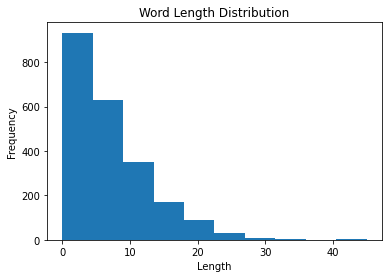

In [28]:
df.word_length.plot(kind='hist')
plt.title('Word Length Distribution', fontsize=12)
plt.xlabel('Length')

As we can see there are so many word length = 0. Let's remove it and visualize again after that

In [29]:
df = df.drop(df[df['word_length']==0].index,axis=0)
df = df.reset_index(drop=True)

Text(0.5, 0, 'Length')

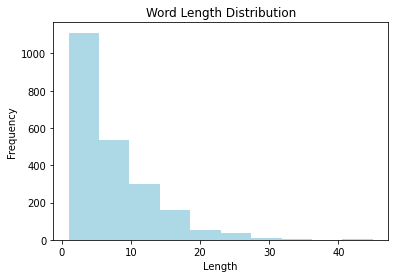

In [30]:
df.word_length.plot(kind='hist', color='lightblue')
plt.title('Word Length Distribution', fontsize=12)
plt.xlabel('Length')

Yaps, finally we can see the clean distribution of word length. From graph above, we can see the longest word is more than 40 words.

-------------------------------
# Tokenization Processing

Let's move to tokenize the word that we have from clean text


In [31]:
word_dict = {}
for i in range(0,len(df['clean_text'])):
    sentence = df['clean_text'][i]
    word_token = word_tokenize(sentence)
    for j in word_token:
        if j not in word_dict:
            word_dict[j] = 1
        else:
            word_dict[j] += 1

In [32]:
len(word_dict)

3214

In [33]:
word_dict

{'nunggu': 37,
 'ber': 1,
 'jam': 79,
 'hingga': 1,
 'aplikasi': 112,
 'terbuka': 1,
 'admin': 385,
 'jawab': 17,
 'skip': 1,
 'sinyal': 117,
 'tidak': 840,
 'stabil': 32,
 'ponsel': 29,
 'nokia': 1,
 'pluslokasi': 1,
 'doyong': 1,
 'kelurahan': 3,
 'gembor': 2,
 'kecamatan': 3,
 'periuk': 1,
 'kota': 9,
 'tangerang': 1,
 'teman': 34,
 'gila': 14,
 'tingkah': 1,
 'kumpul': 1,
 'kepomasa': 1,
 'sih': 100,
 'mengadopsi': 1,
 'bebas': 1,
 'aktif': 9,
 'nomor': 29,
 'hahaha': 7,
 'wkwkwkwk': 5,
 'aamiinnn': 1,
 'terima': 65,
 'kasih': 73,
 'kak': 172,
 'aul': 2,
 'semoga': 23,
 'doa': 1,
 'baiknya': 2,
 'ayi': 4,
 'selamat': 26,
 'ultah': 9,
 'yaa': 82,
 'sehat': 8,
 'bahagia': 8,
 'tercapai': 2,
 'dicita': 2,
 'citain': 2,
 'kadonya': 6,
 'pakai': 157,
 'bersyukur': 3,
 'lancar': 22,
 'hilang': 73,
 'tergantung': 2,
 'lokasinyamungkin': 1,
 'daerah': 18,
 'mu': 6,
 'sinyalnya': 37,
 'paketan': 35,
 'gigabita': 114,
 'berkah': 1,
 'sisa': 14,
 'usianya': 1,
 'aamiin': 11,
 'kecepatan': 7,


-------------------------------------
# Importing Lexicon

Okay, after doing tokenization, what we next is import lexicon. I using lexicon from 


https://github.com/fajri91/InSet


https://github.com/abhimantramb/elang/blob/master/word2vec/utils/swear-words.txt

In [34]:
negasi = ['bukan','tidak','ga','gk']
lexicon = pd.read_csv('/content/drive/MyDrive/data_covid/data/modified_full_lexicon.csv')
lexicon = lexicon.drop(lexicon[(lexicon['word'] == 'bukan')
                               |(lexicon['word'] == 'tidak')
                               |(lexicon['word'] == 'ga')|(lexicon['word'] == 'gk') ].index,axis=0)
lexicon = lexicon.reset_index(drop=True)

In [35]:
lexicon.head(10)

,word,weight,number_of_words
0,hai,3,1
1,merekam,2,1
2,ekstensif,3,1
3,paripurna,1,1
4,detail,2,1
5,pernik,3,1
6,belas,2,1
7,welas,4,1
8,kabung,1,1
9,rahayu,4,1


In [36]:
lexicon_word = lexicon['word'].to_list()
lexicon_num_words = lexicon['number_of_words']

In [37]:
len(lexicon_word)

10248

**Checking if there is words in dictionary that does not included in the lexicon**

In [38]:
ns_words = []
factory = StemmerFactory()
stemmer = factory.create_stemmer()
for word in word_dict.keys():
    if word not in lexicon_word:
        kata_dasar = stemmer.stem(word)
        if kata_dasar not in lexicon_word:
            ns_words.append(word)
len(ns_words)

2213

Let's see what kind of word that not included in lexicon and how many is that

In [39]:
ns_words_list = {k:v for (k,v) in word_dict.items() if ((k in ns_words)&(v>3))}

In [40]:
sorted = sorted(ns_words_list.items(), key=lambda x: x[1], reverse=True)
sorted=sorted[:20]
for i in sorted:
    print(i[0], i[1])

tidak 840
admin 385
internet 309
nya 195
kak 172
pakai 157
sinyal 117
gigabita 114
sih 100
yaa 82
kakak 82
jam 79
bikin 75
nindy 63
bisa 55
email 54
kartu 49
provider 47
semalem 47
komplain 46


We try to visualize the often words in clean text

In [41]:
word_to_plot = df['clean_text'].copy()
word_to_plots = word_to_plot.apply(lambda x: del_word(x,negasi))

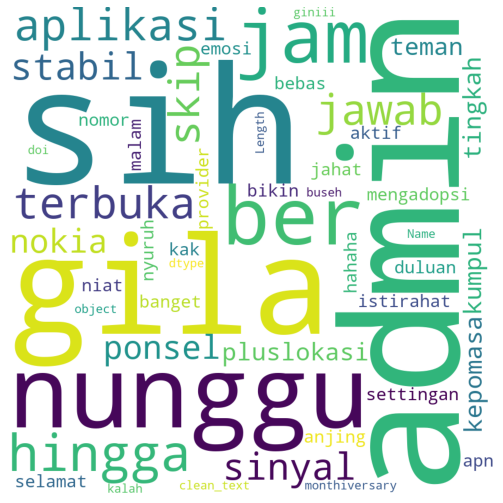

In [42]:
wordcloud = WordCloud(width = 900, height = 900, background_color = 'white', max_words = 1000
                      , min_font_size = 21).generate(str(word_to_plots))
#plot the word cloud
fig = plt.figure(figsize = (9,9), facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

------------------------------
# Sentiment Analysis

Next we do calculate the sentiment for each sentence or tweet using lexicon values.

In [43]:
sencol =[]
senrow =np.array([])
nsen = 0
factory = StemmerFactory()
stemmer = factory.create_stemmer()
sentiment_list = []
# function to write the word's sentiment if it is founded
def found_word(ind,words,word,sen,sencol,sentiment,add):
    # if it is already included in the bag of words matrix, then just increase the value
    if word in sencol:
        sen[sencol.index(word)] += 1
    else:
    #if not, than add new word
        sencol.append(word)
        sen.append(1)
        add += 1
    #if there is a negation word before it, the sentiment would be the negation of it's sentiment
    if (words[ind-1] in negasi):
        sentiment += -lexicon['weight'][lexicon_word.index(word)]
    else:
        sentiment += lexicon['weight'][lexicon_word.index(word)]
    
    return sen,sencol,sentiment,add
            
# checking every words, if they are appear in the lexicon, and then calculate their sentiment if they do
for i in range(len(df)):
    nsen = senrow.shape[0]
    words = word_tokenize(df['clean_text'][i])
    sentiment = 0 
    add = 0
    prev = [0 for ii in range(len(words))]
    n_words = len(words)
    if len(sencol)>0:
        sen =[0 for j in range(len(sencol))]
    else:
        sen =[]
    
    for word in words:
        ind = words.index(word)
        # check whether they are included in the lexicon
        if word in lexicon_word :
            sen,sencol,sentiment,add= found_word(ind,words,word,sen,sencol,sentiment,add)
        else:
        # if not, then check the root word
            kata_dasar = stemmer.stem(word)
            if kata_dasar in lexicon_word:
                sen,sencol,sentiment,add= found_word(ind,words,kata_dasar,sen,sencol,sentiment,add)
        # if still negative, try to match the combination of words with the adjacent words
            elif(n_words>1):
                if ind-1>-1:
                    back_1    = words[ind-1]+' '+word
                    if (back_1 in lexicon_word):
                        sen,sencol,sentiment,add= found_word(ind,words,back_1,sen,sencol,sentiment,add)
                    elif(ind-2>-1):
                        back_2    = words[ind-2]+' '+back_1
                        if back_2 in lexicon_word:
                            sen,sencol,sentiment,add= found_word(ind,words,back_2,sen,sencol,sentiment,add)
    # if there is new word founded, then expand the matrix
    if add>0:  
        if i>0:
            if (nsen==0):
                senrow = np.zeros([i,add],dtype=int)
            elif(i!=nsen):
                padding_h = np.zeros([nsen,add],dtype=int)
                senrow = np.hstack((senrow,padding_h))
                padding_v = np.zeros([(i-nsen),senrow.shape[1]],dtype=int)
                senrow = np.vstack((senrow,padding_v))
            else:
                padding =np.zeros([nsen,add],dtype=int)
                senrow = np.hstack((senrow,padding))
            senrow = np.vstack((senrow,sen))
        if i==0:
            senrow = np.array(sen).reshape(1,len(sen))
    # if there isn't then just update the old matrix
    elif(nsen>0):
        senrow = np.vstack((senrow,sen))
        
    sentiment_list.append(sentiment)

In [44]:
len(sentiment_list)

2208

In [45]:
sencol.append('sentiment')
sentiment_array = np.array(sentiment_list).reshape(senrow.shape[0],1)
sentiment_data = np.hstack((senrow,sentiment_array))
df_sen = pd.DataFrame(sentiment_data,columns = sencol)

In [46]:
df_sen.head(10)

,nunggu,aplikasi,terbuka,jawab,stabil,gila,tingkah,bebas,aktif,terima,kasih,moga,doa,baiknya,selamat,sehat,bahagia,tercapai,kado,bersyukur,lancar,hilang,tergantung,paket,berkah,sisa,aamiin,kecepatan,kelar,lelah,mama,lucu,kasi,tua,thank,doang,buka,daftar,dapatkan,eror,...,dibeliin,berumur,adil,peka,pegawai,block,timbul,sanjung,amburadul,pinggir,anjer,labrak,gela,istirahat,maunya,bergantung,hoki,iseng,nemu,diserang,bantuin,join,bot,invalid,kuning,hijau,lampu,cash,sedia,ken,ora,kenek,gusti,nasi,mudahan,rusak,ramai,gambar,jahat,sentiment
0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-3
3,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-2
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10
7,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21
8,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18


In [47]:
cek_df = pd.DataFrame([])
cek_df['text'] = df['original_text'].copy()
cek_df['sentiment']  = df_sen['sentiment'].copy()

In [48]:
cek_df

,text,sentiment
0,@byu_id apa aku harus nunggu ber-jam² hingga a...,0
1,Min @byu_id tolong jawab lah. Jangan di skip.,3
2,@byu_id min beberapa hari belakangan ini kok s...,-3
3,ada\n(selalu ada buat teman)\ngokil\n(tingkah ...,1
4,@SpeciaIONEe @worksfess @IndosatCare @triindon...,-2
...,...,...
2203,@byu_id min minta settingan APN dong,0
2204,jahat banget kamu nyuruh aku istirahat duluan ...,-7
2205,Selamat tiga bulan bersama kak:) https://t.co/...,5
2206,LU NIAT BIKIN PROVIDER GAKSI ANJG EMOSI @byu_id,-1


Finally we could know how the sentiment values of each tweet. From here, he do create classification for each tweet. 

**0 is classified to netral, > 0 is positif, < 0 is negatif.**

In [49]:
df['sentiment'] = df_sen['sentiment']

In [50]:
for i in df['sentiment']:
  if i < 0:
    df['sentiment_value'] = 'negatif'
  else:
    df['sentiment_value'] = 'positif'

In [51]:
for i in df['sentiment']:
  if i == 0:
    df['sentiment_value'] = 'netral'

In [52]:
df[df['sentiment'] == 0]

,id,created_at,source,original_text,clean_text,lang,favorite_count,retweet_count,original_author,possibly_sensitive,hashtags,user_mentions,place,place_coord_boundaries,word_length,sentiment,sentiment_value
0,1478564382783119362,Wed Jan 05 03:09:53 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",@byu_id apa aku harus nunggu ber-jam² hingga a...,nunggu ber jam hingga aplikasi terbuka,in,0,0,rickjak16,False,NaN,byu_id,Planet Namex,NaN,6,0,netral
5,1478555358641590272,Wed Jan 05 02:34:02 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",@SpeciaIONEe @worksfess @IndosatCare @triindon...,wkwkwkwk,in,0,0,bangvalash,NaN,NaN,"SpeciaIONEe, worksfess, IndosatCare, triindone...","Mars, PA",NaN,1,0,netral
42,1478527181563199489,Wed Jan 05 00:42:04 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",Kenapa yah @byu_id akhir akhir ini sinyalnya n...,yah sinyalnya ndet ndet an hmmm,in,0,0,VirmanAfri,NaN,NaN,byu_id,Kelapa duanya utara,NaN,6,0,netral
43,1478526404257931266,Wed Jan 05 00:38:59 +0000 2022,"<a href=""http://twitter.com/download/android"" ...","Finally, a telco provider that lets you choose...",finally a telco provider that lets you choose ...,en,0,0,conoBARUtau,False,NaN,NaN,NaN,NaN,26,0,netral
47,1478480646725013504,Tue Jan 04 21:37:09 +0000 2022,"<a href=""https://dlvrit.com/"" rel=""nofollow"">d...","Norman Hancock Obituary (1930 - 2021) - Mesa, ...",norman hancock obituary mesa az,eu,1,0,BYU_News,False,NaN,NaN,Utah County,NaN,5,0,netral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2189,1478586489155948546,Wed Jan 05 04:37:44 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",@avfogato @bangvalash @worksfess @IndosatCare ...,gigabita,in,0,0,SpeciaIONEe,NaN,NaN,"avfogato, bangvalash, worksfess, IndosatCare, ...",UMP 1.8,NaN,1,0,netral
2193,1478583305733750791,Wed Jan 05 04:25:05 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",@byu_id sudah setahun hamdallaah meskipun ku s...,setahun hamdallaah meskipun ku mengeluh signal...,in,0,0,SSusaneey,NaN,NaN,byu_id,"Bandung, Jawa Barat",NaN,21,0,netral
2195,1478582829499908102,Wed Jan 05 04:23:11 +0000 2022,"<a href=""https://mobile.twitter.com"" rel=""nofo...",@SpeciaIONEe @bangvalash @worksfess @IndosatCa...,paket internet sebulan paling tidak on nya kayak,in,1,0,haimeidy,False,NaN,"SpeciaIONEe, bangvalash, worksfess, IndosatCar...",Yogyakarta,NaN,8,0,netral
2198,1478577175733231620,Wed Jan 05 04:00:43 +0000 2022,"<a href=""https://mobile.twitter.com"" rel=""nofo...",@unamujerelegant Kartu @byu_id,kartu,eu,0,0,austronesiaa,NaN,NaN,"unamujerelegant, byu_id","Kepulauan Riau, Indonesia",NaN,1,0,netral


In [53]:
#df.to_csv('/content/drive/MyDrive/data_covid/data/this/byu_sentiment_dataset.csv')

# EDA

In [59]:
df = pd.read_csv('/content/drive/MyDrive/data_covid/data/this/byu_sentiment_dataset_clean.csv')

**Where the place that tweet created at? How much from each places for each sentiment labels?**

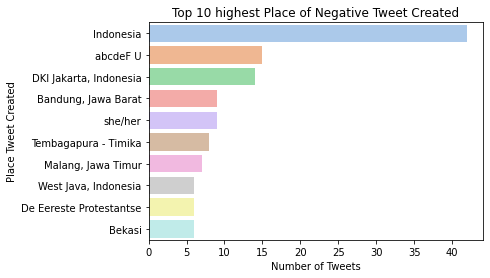

In [75]:
#place for negative sentiment value
place_neg = df[df['sentiment_value'] == 'negatif'].groupby('place')['sentiment_value'].count().reset_index().sort_values(by='sentiment_value', ascending=False)[:10]

#place for positive sentiment value
place_pos = df[df['sentiment_value'] == 'positif'].groupby('place')['sentiment_value'].count().reset_index().sort_values(by='sentiment_value', ascending=False)[:10]

import seaborn as sns
sns.barplot(x=place_neg['sentiment_value'], y=place_neg['place'], palette='pastel')
plt.title('Top 10 highest Place of Negative Tweet Created', fontsize=12)
plt.xlabel('Number of Tweets', fontsize=10)
plt.ylabel('Place Tweet Created', fontsize=10)
plt.show()


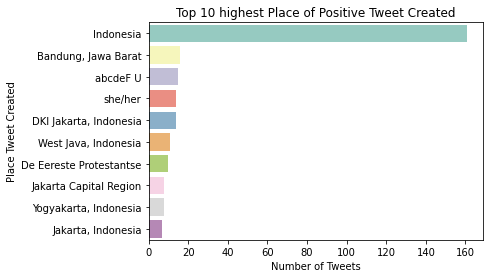

In [76]:
sns.barplot(x=place_pos['sentiment_value'], y=place_pos['place'], palette='Set3')
plt.title('Top 10 highest Place of Positive Tweet Created', fontsize=12)
plt.xlabel('Number of Tweets', fontsize=10)
plt.ylabel('Place Tweet Created', fontsize=10)
plt.show()

**How much language from tweets and what the top 10 highest of kind of language**

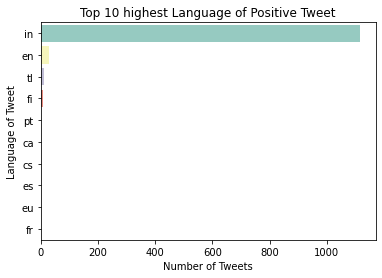

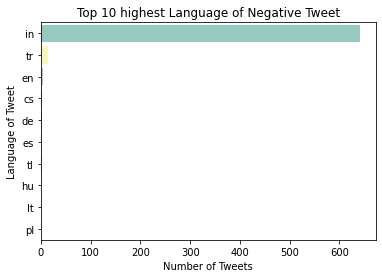

In [79]:
# negative tweet by language
lang_neg = df[df['sentiment_value'] == 'negatif'].groupby('lang')['sentiment_value'].count().reset_index().sort_values(by='sentiment_value', ascending=False)[:10]
# positive tweet by language
lang_pos = df[df['sentiment_value'] == 'positif'].groupby('lang')['sentiment_value'].count().reset_index().sort_values(by='sentiment_value', ascending=False)[:10]

#visualize
sns.barplot(x=lang_pos['sentiment_value'], y=lang_pos['lang'], palette='Set3')
plt.title('Top 10 highest Language of Positive Tweet', fontsize=12)
plt.xlabel('Number of Tweets', fontsize=10)
plt.ylabel('Language of Tweet', fontsize=10)
plt.show()

#visualize
sns.barplot(x=lang_neg['sentiment_value'], y=lang_neg['lang'], palette='Set3')
plt.title('Top 10 highest Language of Negative Tweet', fontsize=12)
plt.xlabel('Number of Tweets', fontsize=10)
plt.ylabel('Language of Tweet', fontsize=10)
plt.show()
